<a href="https://colab.research.google.com/github/DimaMirana/DataAnalysisWithPython/blob/master/TestTemp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#check version of tensor
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import time

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
#print(imdb.keys()) #dict_keys(['test', 'train', 'unsupervised'])

In [ ]:
train_data, test_data = imdb['train'], imdb['test']

sentences = []
labels = []

# merge default train test for spliting it into 80/20 later
for s,l in train_data:
  sentences.append(str(s.numpy()))
  labels.append(l.numpy())
  
for s,l in test_data:
  sentences.append(str(s.numpy()))
  labels.append(l.numpy())

#convert str to np array
sentences_final = np.array(sentences) 
labels_final = np.array(labels)

In [ ]:
print(sentences_final.shape) 
print(labels_final.shape)

(50000,)
(50000,)


In [ ]:
indices = np.arange(0,50000)
np.random.shuffle(indices)
sentences_final = sentences_final[indices]
labels_final = labels_final[indices]

In [ ]:
#print(np.unique(labels_final)) #binary so only 2 type 0,1
#print(len(np.unique(np.hstack(sentences_final)))) #49582 unique words in the reviews
# review_length = [len(i) for i in sentences_final] #get all the length of each review stack in an array [1146, 427, 1058, 715, 1853,...]
#print(max(review_length)) #max length of a review in index 13741
#print(min(review_length)) #min length of a review in index 35
# print(np.mean(review_length)) #avg review length 1371.00638
# print(round(np.std(review_length))) #standard deviation 995.0

In [27]:
#split into training set. if want to change into different portion changes the test portion here. it's 80/20 now
training_size=50000
test_portion=.8
split = int(training_size * test_portion)

In [28]:
training_sentences = sentences_final[0:split]
testing_sentences = sentences_final[split:]
training_labels = labels_final[0:split]
testing_labels = labels_final[split:]

In [29]:
vocab_size = 50000
embedding_dim = 18
max_length = 13741
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [30]:
#add padding into traing and testing features so all the review in same length
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [31]:
#converting all the features and labels into np.array
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [32]:
#reverse the word index:name pair
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [ ]:
print(decode_review(training_padded[13741])) #padded review in str -> i see that c thomas howell has appeared in many movies since his heyday in the 80s as an accomplished young actor br br i bought ? ? ?
print(training_sentences[13741]) #raw review in str  -> I see that C. Thomas Howell has appeared in many movies since his heyday in the 80s as an accomplished young actor.<br /><br />I
print(training_labels[2]) #label for that review ->0
print(testing_sentences[1])
print(testing_labels[1])

b'i went into this film expecting it to be similar to the matrix or pi boy was i wrong yes there is a poorly written poorly acted plot in the movie with cg animated cells and peptides to boot however the real focus of the film are the expert talking heads spewing out new age feel good hogwash in between plot segments br br sure it stars off innocently enough there is a little bit of real quantum physics in the beginning it states for example that <OOV> exist as both particle and wave and that an atom is mostly empty space however the movie takes a giant and unscientific leap saying that sub atomic quantum effects happen on large scales as well the talking heads take it even further according to them the following are true br br when columbus arrived in the caribbean the natives were unable to see his ships because their minds were incapable of perceiving something so different meditation can reduce the murder rate with positive thought you can walk on water your thoughts can change the

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, kernel_initializer='lecun_normal', activation='selu'),
    tf.keras.layers.AlphaDropout(0.01),
    tf.keras.layers.Dense(16, kernel_initializer='lecun_normal', activation='selu'),
    tf.keras.layers.AlphaDropout(0.01),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 13741, 18)         900000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 18)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                608       
_________________________________________________________________
alpha_dropout_4 (AlphaDropou (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
alpha_dropout_5 (AlphaDropou (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [34]:
num_epochs = 30
batch_size = 128
tick = time.time()
history = model.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose = 1)
tock = time.time()
print('Took', time.strftime("%H:%M:%S", time.gmtime(tock - tick)))

Epoch 1/30
313/313 [==============================] - 51s 163ms/step - loss: 0.7003 - accuracy: 0.5001 - val_loss: 0.6936 - val_accuracy: 0.4945
Epoch 2/30
313/313 [==============================] - 51s 163ms/step - loss: 0.6957 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.4945
Epoch 3/30
313/313 [==============================] - 51s 162ms/step - loss: 0.6945 - accuracy: 0.5005 - val_loss: 0.6928 - val_accuracy: 0.5065
Epoch 4/30
313/313 [==============================] - 52s 165ms/step - loss: 0.6937 - accuracy: 0.5077 - val_loss: 0.6922 - val_accuracy: 0.5451
Epoch 5/30
313/313 [==============================] - 55s 176ms/step - loss: 0.6925 - accuracy: 0.5215 - val_loss: 0.6895 - val_accuracy: 0.5080
Epoch 6/30
313/313 [==============================] - 51s 164ms/step - loss: 0.6849 - accuracy: 0.5638 - val_loss: 0.6571 - val_accuracy: 0.7074
Epoch 7/30
313/313 [==============================] - 51s 163ms/step - loss: 0.6170 - accuracy: 0.6835 - val_loss: 0.5249 - val_ac

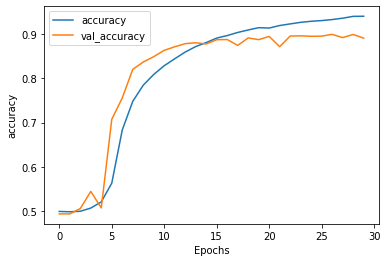

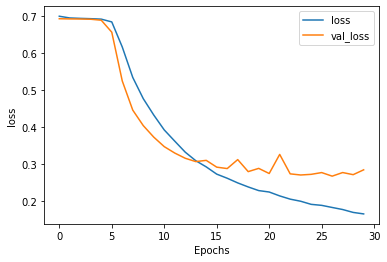

In [35]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [36]:
loss, acc = model.evaluate(testing_padded, testing_labels)
print('Loss:', loss, 'Accuracy:', acc)

313/313 [==============================] - 7s 21ms/step - loss: 0.2841 - accuracy: 0.8903
Loss: 0.28410887718200684 Accuracy: 0.8902999758720398


In [38]:
model.save('./dense.h5')

In [39]:
from tensorflow.keras.models import load_model

loaded_model = load_model('./dense.h5')

In [40]:
loss, acc = loaded_model.evaluate(testing_padded, testing_labels)
print('Loss:', loss, 'Accuracy:', acc)

313/313 [==============================] - 7s 21ms/step - loss: 0.2841 - accuracy: 0.8903
Loss: 0.28410887718200684 Accuracy: 0.8902999758720398
